In [ ]:
# March 2024
# Model training - XLM-RoBERTa using pytorch
# Violeta Berdejo-Espinola

In [10]:
pip install transformers

  Using cached transformers-4.45.2-py3-none-any.whl.metadata (44 kB)
  Using cached huggingface_hub-0.26.1-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.20.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
Using cached transformers-4.45.2-py3-none-any.whl (9.9 MB)
Using cached huggingface_hub-0.26.1-py3-none-any.whl (447 kB)
Using cached tokenizers-0.20.1-cp311-cp311-macosx_11_0_arm64.whl (2.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import os
import mpu
import torch
import torch.nn as nn

print(torch.backends.mps.is_built()) # checking if mps is available 
device = torch.device('mps')
print(device)

import platform; 
print(platform.mac_ver()) # checking pytorch version for mac - should be arm54

True
mps
('14.7', ('', '', ''), 'arm64')


# read data

In [13]:
X_train = mpu.io.read('../data/X_train_xlm.pickle').to(device)
X_test = mpu.io.read('../data/X_test_xlm.pickle').to(device)
y_train = mpu.io.read('../data/y_train_xlm.pickle').to(device)
y_test = mpu.io.read('../data/y_test_xlm.pickle').to(device)

class_weights = mpu.io.read('../data/class_weights.pickle')

In [17]:
X_train

{'input_ids': tensor([[     0, 107950,  43269,  ...,      1,      1,      1],
        [     0,  45709,   4503,  ...,      1,      1,      1],
        [     0,    527,   7695,  ...,      1,      1,      1],
        ...,
        [     0,  10934,    318,  ...,      1,      1,      1],
        [     0, 177652,     31,  ...,   1124, 205292,      2],
        [     0,  84790,  49835,  ...,      1,      1,      1]],
       device='mps:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='mps:0')}

In [16]:
# X_train_ros = mpu.io.read('../data/embedding_train_ros.pickle')
# X_test_ros = mpu.io.read('../data/embedding_test_ros.pickle')
# y_train_ros = mpu.io.read('../data/y_train_emb_ros.pickle')
# y_test_ros = mpu.io.read('../data/y_test_emb_ros.pickle')

X_train_ros = torch.from_numpy(X_train_ros).to(device)
X_test_ros = torch.from_numpy(X_test_ros).to(device)
y_train_ros = torch.tensor(y_train_ros).to(device)
y_test_ros = torch.tensor(y_test_ros).to(device)

NameError: name 'X_train_ros' is not defined

In [6]:
len(X_train['input_ids'])
y_train.bincount()

tensor([3966,   49], device='mps:0')

# model training

In [7]:
from transformers import (XLMRobertaForSequenceClassification, AutoTokenizer)

id2label = {'negative': 0, 
            'positive': 1}
label2id = {0: 'negative',
            1: 'positive'}

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base',
                                                            num_labels=2, 
                                                            id2label=id2label, 
                                                            label2id=label2id).to(device)

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# freeze transformer model parametres

for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# creating dataloaders

from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 128

# TensorDataset(input_features, labels)

train_xlm = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
train_sampler = RandomSampler(train_xlm)
train_dataloader = DataLoader(train_xlm, sampler=train_sampler, batch_size=batch_size)

test_xlm = TensorDataset(X_test['input_ids'], X_test['attention_mask'], y_test)
test_dataloader = DataLoader(test_xlm, batch_size=batch_size)

In [13]:
# epoch:  1 forward and backward pass of ALL training examples
# bacth size: number of training samples in one forward and backwards pass
# number of iterations: number of passes until the model has seen ALL examples. Each pass using batch_size number of samples
# if 100 samples, batch_size=20, then it does 5 iterations per epoch to see ALL examples

# if learning rate is too small:
# - model goes through many iteartions to converge
# - the loss does not change

# defining parametres for gardient descent

epochs = 50

# loss function and optimizer

loss_function = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr = 1) # try 0.1

# total number of training steps is number of batches * number of epochs

total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler

from transformers import get_linear_schedule_with_warmup

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
                                            

In [14]:
# function to train model

def Trainer(model, dataloader, epochs, batch_size, device, optimizer, scheduler):
    # Store the average loss after each epoch 
    loss_values = []

    # number of total steps/iterations for each epoch
    print('total steps per epoch: ', len(dataloader) // batch_size)

    # looping over epochs
    for epoch_i in range(0, epochs):
        print('training on epoch: ', epoch_i)

        # set start time 
        t0 = time.time()
        # reset total loss
        total_loss = 0

        # model in training 
        model.train()

        # loop through batch 
        for step, batch in enumerate(dataloader):

            # Progress update every 50 step 
            if step % 50 == 0 and not step == 0:
                print('training on step: ', step)
                print('total time used is: {0:.2f} s'.format(time.time() - t0))

            # load data from dataloader 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # clear any previously calculated gradients 
            model.zero_grad()

            # get outputs
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
            # get loss
            loss = outputs[0]
            
            loss.backward()
            
            # update optimizer
            optimizer.step()

            # update learning rate 
            scheduler.step()

            # total loss
            total_loss += loss.item()

            # clip the norm of the gradients to 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)         

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)
        
        print("average training loss: {0:.4f}".format(avg_train_loss))

    return loss_values

In [16]:
torch.manual_seed(42)

import time
results5  = Trainer(model, train_dataloader, epochs, batch_size, device, optimizer, scheduler)

total steps per epoch:  0
training on epoch:  0
average training loss: 4.2812
training on epoch:  1
average training loss: 3.7304
training on epoch:  2
average training loss: 1.9712
training on epoch:  3
average training loss: 1.6155
training on epoch:  4


KeyboardInterrupt: 

In [15]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

import time
model = ...
train_dataloader
optimizer
scheduler
results5  = Trainer(model, train_dataloader, epochs, batch_size, device, optimizer, scheduler)

total steps per epoch:  0
training on epoch:  0
average training loss: 2.3174
training on epoch:  1
average training loss: 1.4516
training on epoch:  2
average training loss: 2.5991
training on epoch:  3
average training loss: 2.4311
training on epoch:  4
average training loss: 9.6161
training on epoch:  5
average training loss: 7.4811
training on epoch:  6
average training loss: 2.7938
training on epoch:  7
average training loss: 1.4248
training on epoch:  8
average training loss: 3.4504
training on epoch:  9
average training loss: 1.7083
training on epoch:  10


KeyboardInterrupt: 

In [23]:
torch.manual_seed(42)

import time
results5  = Trainer(model, train_dataloader, epochs, batch_size, device, optimizer, scheduler)

total steps per epoch:  0
training on epoch:  0
average training loss: 1.8568
training on epoch:  1
average training loss: 0.7086
training on epoch:  2
average training loss: 1.5016
training on epoch:  3
average training loss: 1.5525
training on epoch:  4
average training loss: 1.1286
training on epoch:  5
average training loss: 0.7272
training on epoch:  6
average training loss: 0.8362
training on epoch:  7
average training loss: 0.9033
training on epoch:  8
average training loss: 0.9136
training on epoch:  9
average training loss: 0.6585
training on epoch:  10
average training loss: 0.5085
training on epoch:  11
average training loss: 0.5193
training on epoch:  12
average training loss: 0.4791
training on epoch:  13
average training loss: 0.4123
training on epoch:  14
average training loss: 0.5101
training on epoch:  15
average training loss: 0.4043
training on epoch:  16
average training loss: 0.3794
training on epoch:  17
average training loss: 0.3867
training on epoch:  18
average

In [27]:
# Test

t0 = time.time()

# model in validation mode
model.eval()

# save prediction
predictions,true_labels =[],[]

# evaluate data for one epoch
for batch in test_dataloader:

    # Add batch to device
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # get output
    logits = outputs[0]

    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 62.11 s


In [37]:
true_labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [36]:
# convert numeric label to string

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(y_test)
target_num = le.transform(y_test)

final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
results_ts = Trainer(model, test_dataloader, epochs, batch_size, device, optimizer, scheduler)

In [22]:
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping

# create engine object
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    
    return -val_loss # an improvement is considered if the score is higher

handler = EarlyStopping(patience=5, score_function=score_function, trainer=Trainer(model, train_dataloader, epochs, batch_size, device, optimizer, scheduler))

total steps per epoch:  0
training on epoch:  0
average training loss: 3.1658
training on epoch:  1
average training loss: 4.9523
training on epoch:  2
average training loss: 5.2118
training on epoch:  3
average training loss: 9.5699
training on epoch:  4
average training loss: 7.1408
training on epoch:  5


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# d = pd.read_csv('../results/transformer_model_loss.csv')
df = pd.DataFrame({'2-epochs': pd.Series(results3),
                  '13-epochs': pd.Series(results4),
                  '18-epochs': pd.Series(results5)})
# df = pd.concat([d, dd], axis=1)
df
# df = df.drop(columns='Unnamed: 0').iloc[:,[0,1,2,4,3]]
print(df)
df.to_csv('../results/model_loss2.csv')

/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_67385/229306452.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


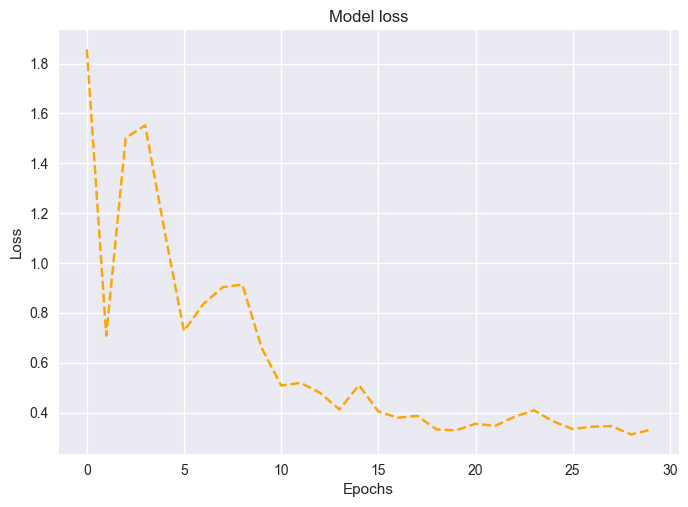

(None, None)

In [24]:
# plot model loss

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

def plot_loss(epoch, results, name):
    
    # plot
    plt.plot(epoch, results, linestyle='--',color='orange')
    # title
    plt.title('Model loss')
    # x label
    plt.xlabel('Epochs')
    # y label
    plt.ylabel('Loss')

    plt.legend(loc='best')
    return plt.savefig(fname=name, dpi=800), plt.show()

# plot
epoch = range(0,epochs)

plot_loss(epoch, results, name='../results/Loss_epochs_30_ts.png')

In [ ]:
# predict on the test set

import numpy as np

t0 = time.time()

def Eval(model, test_dataloader, device, ):
# model in validation mode
model.eval()

# save prediction
predictions,true_labels =[],[]

# evaluate data for one epoch
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    
    # get output
    logits = outputs[0]
    
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('mpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten() # predicitions with the highest probability
    
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

In [ ]:
# loss_values, outputs

In [ ]:
predictions[:3]

In [ ]:
# concatenate list of arrays

final_prediction_list = np.concatenate(predictions)
final_truelabel_list = np.concatenate(true_labels)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cr = classification_report(final_truelabel_list, 
                           final_prediction_list)
print(cr)

In [ ]:
loss_values_2

In [ ]:
# storing loss values

loss = pd.DataFrame({'lr: 0.001': loss_values, 
                    'lr: 0.01': loss_values_2})

In [ ]:
# lineplot

import matplotlib.pyplot as plt 

plt.style.use('ggplot')

x_epoch = list(range(0, epochs))

y_loss = loss_values

plt.plot(x_epoch, y_loss, color='#881111', linestyle=':', linewidth=1, marker='.', label='learning rate: 0.001')

y_loss_2 = loss_values_2

plt.plot(x_epoch, y_loss_2, 'b--', label='learning rate: 0.01')

plt.xlabel("iterations")
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('plot.png')

plt.show

In [ ]:
# Lastly, we might train the neural network with mini-batch (stochastic) gradient descent, which means that we split the original training dataset into 𝑀=⌈𝑁/𝐵⌉
#  batches, where 
#     𝑁 is the size of the original dataset and 
#     𝐵 is the batch size (typical numbers are 32 or 64). So, if you have, say, 𝑁=10000
#  and 𝐵=32
# , then we have 𝑀=312
#  mini-batches; so, for each epoch, you will perform 312 gradient steps, one for each mini-batch.